In [ ]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

# import pmdarima as pm

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns' , None)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [ ]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_merge_select_mhd_teh_select_date['count'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['count']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['count'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="count")
    plt.legend()
    plt.grid(True);

In [ ]:
df_merge = pd.read_csv('/content/drive/MyDrive/charter project/Arima-Preprocesss.csv')

In [ ]:
df_merge['origin']= df_merge.origin.str.capitalize()
df_merge['destination']= df_merge.destination.str.capitalize()

In [ ]:
df_merge['miladi-flight-date'] = pd.to_datetime(df_merge['miladi-flight-date'])

In [ ]:
df_merge = df_merge.groupby([pd.Grouper(key = 'miladi-flight-date' , freq = '1D') , 'origin' , 'destination' , 'holiday']).agg({'count' : np.sum})
df_merge = df_merge.reset_index()

In [ ]:
df_merge

,miladi-flight-date,origin,destination,holiday,count
0,2018-10-28,Shiraz,Tehran,0,1
1,2018-10-28,Tabriz,Tehran,0,2
2,2018-10-29,Ahvaz,Tehran,0,1
3,2018-10-29,Tehran,Mashhad,0,1
4,2018-10-29,Tehran,Sanandaj,0,1
...,...,...,...,...,...
187613,2023-03-20,Tehran,Kish island,1,7
187614,2023-03-20,Tehran,Mashhad,1,1
187615,2023-03-22,Tehran,Mashhad,1,1
187616,2023-03-31,Kish island,Tehran,0,4


In [ ]:
# df_merge_select = df_merge[['miladi-flight-date', 'hour', 'origin', 'destination', 'count' ,'weekend','holiday']]

In [ ]:
# df_merge_select['miladi-flight-date'] = df_merge_select['miladi-flight-date'].apply(str) + ' ' +  df_merge_select['hour'].apply(str) +':' + '00' + ':' + '00'

In [ ]:
# df_merge_select['miladi-flight-date'] = pd.to_datetime(df_merge_select['miladi-flight-date'])

In [ ]:
df_merge_select = df_merge.set_index('miladi-flight-date')

In [ ]:
df_merge_select = df_merge_select.sort_values(by = 'miladi-flight-date')

In [ ]:
df_merge_select.head(1)

,origin,destination,holiday,count
miladi-flight-date,,,,
2018-10-28,Shiraz,Tehran,0,1


In [ ]:
df_merge_select_mhd_teh = df_merge_select[(df_merge_select['origin'] == 'Tehran') & (df_merge_select['destination'] == 'Mashhad')]

In [ ]:
df_merge_select_mhd_teh_select_date = df_merge_select_mhd_teh.loc[:'2022-12-10' , :]

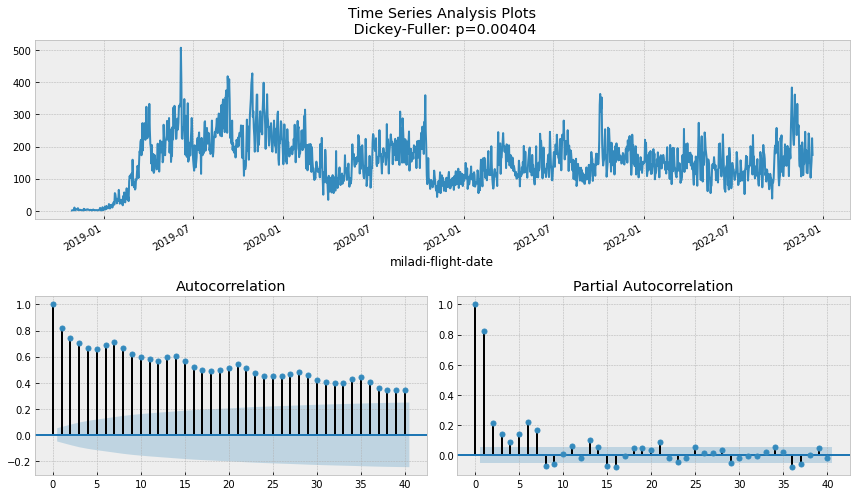

In [ ]:
tsplot(df_merge_select_mhd_teh_select_date['count'], lags=40)

In [ ]:
# results = pm.auto_arima(df_merge_select_mhd_teh_select_date['count'],stationary=False , test = 'adf' , max_p=10,max_q=10 ,trend='c',  n_jobs=-1,maxiter=50,random_state=85)

In [ ]:
# results.summary()

In [ ]:
# results.plot_diagnostics()

In [ ]:
df_merge_select_mhd_teh_select_date_f = df_merge_select_mhd_teh_select_date[['count' , 'holiday']]

<Figure size 1440x1440 with 0 Axes>

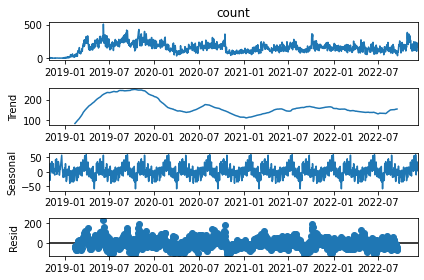

In [ ]:
plt.figure(figsize = (20,20))
decomposed_google_volume = sm.tsa.seasonal_decompose(df_merge_select_mhd_teh_select_date_f["count"],period=168) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

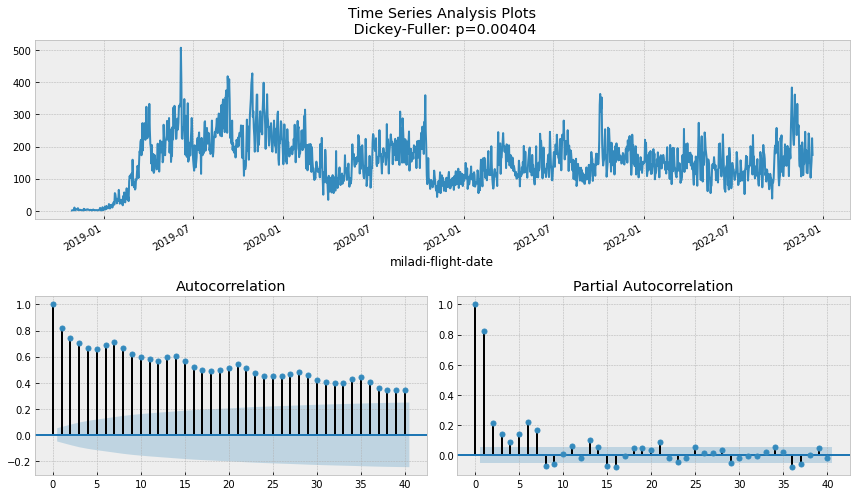

In [ ]:
tsplot(df_merge_select_mhd_teh_select_date_f['count'], lags=40)

In [ ]:
df_rolling = df_merge_select_mhd_teh_select_date_f - df_merge_select_mhd_teh_select_date_f.rolling(30).mean()
df_rolling = df_rolling.dropna()

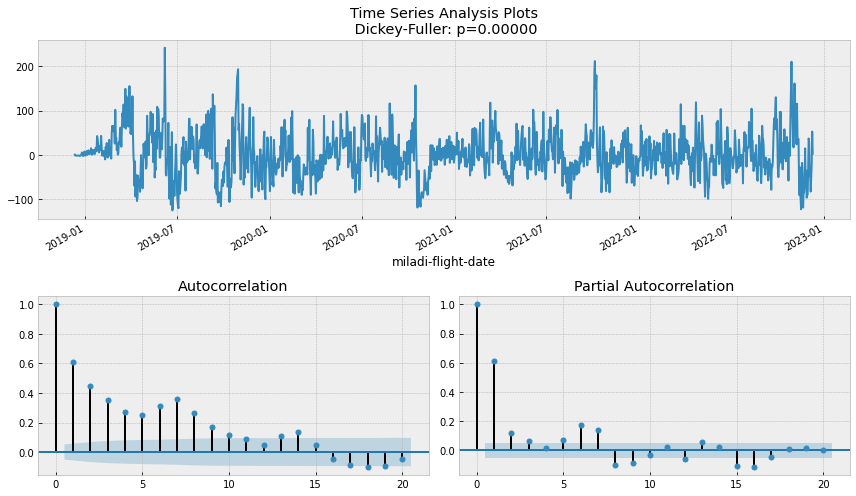

In [ ]:
tsplot(df_rolling['count'], lags=20)

In [ ]:
ps = range(0, 6)
d=0 
qs = range(0, 6)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [ ]:
# pip install pmdarima

In [ ]:
# import pmdarima as pm

In [ ]:
# results = pm.auto_arima(df_merge_select_mhd_teh_select_date['count'] ,
#                         test = 'adf' ,m = 16 ,trend='ct', trace = True,  n_jobs=-1,
#                         maxiter=50,random_state=85)

In [ ]:
# results.summary()

In [ ]:
# results.plot_diagnostics()

In [ ]:
# result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
# result_table.head()

In [ ]:
# # p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_merge_select_mhd_teh_select_date_f['count'], order=(0,0,1), 
                                        seasonal_order=(0,0,2,16)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                        SARIMAX Results                                        
Dep. Variable:                                   count   No. Observations:                 1483
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 16)   Log Likelihood               -8473.482
Date:                                 Wed, 21 Dec 2022   AIC                          16954.964
Time:                                         08:09:12   BIC                          16976.171
Sample:                                              0   HQIC                         16962.869
                                                - 1483                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6446      0.020     31.934      0.000       0.605       0

In [ ]:
best_model.

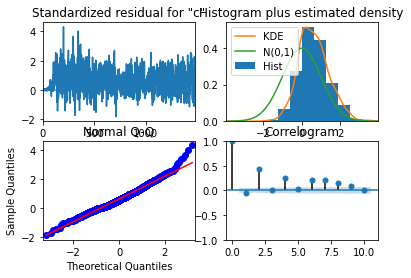

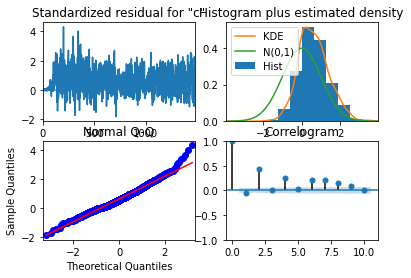

In [ ]:
best_model.plot_diagnostics()

In [ ]:
my_series = df_merge_select_mhd_teh_select_date_f['count']

In [ ]:
# plotSARIMA(df_merge_select_mhd_teh_select_date_f['count'], best_model, 50)

In [ ]:
# forecast = best_model.get_forecast(steps = 50).predicted_mean

# # calculate error, again having shifted on s+d steps from the beginning
# # error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

# plt.figure(figsize=(15, 7))
# # plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
# plt.plot(forecast.values, color='r', label="best_model")
# # plt.axvspan(df_merge_select_mhd_teh_select_date_f.index[-1], forecast.index, alpha=0.5, color='lightgrey')
# plt.plot(df_merge_select_mhd_teh_select_date_f['count'], label="actual")
# plt.legend()
# plt.grid(True);

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 9.9 MB 45.6 MB/s 


In [ ]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_merge_select_mhd_teh_select_date_f['count'], 
                      start_p=1, 
                      start_q=1,
                      n_jobs=-1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1483
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7551.647
Date:                Wed, 21 Dec 2022   AIC                          15115.295
Time:                        08:09:50   BIC                          15147.106
Sample:                             0   HQIC                         15127.152
                               - 1483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4189      0.034     12.160      0.000       0.351       0.486
ar.L2          0.9538      0.027     34.724      0.000       0.900       1.008
ar.L3         -0.3751      0.032    -11.867      0.0

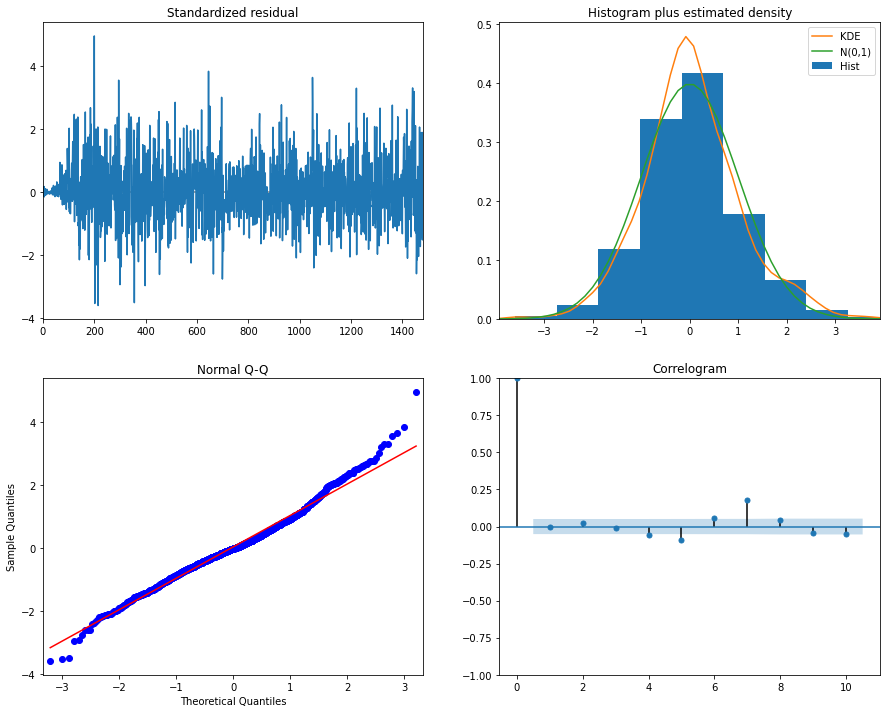

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

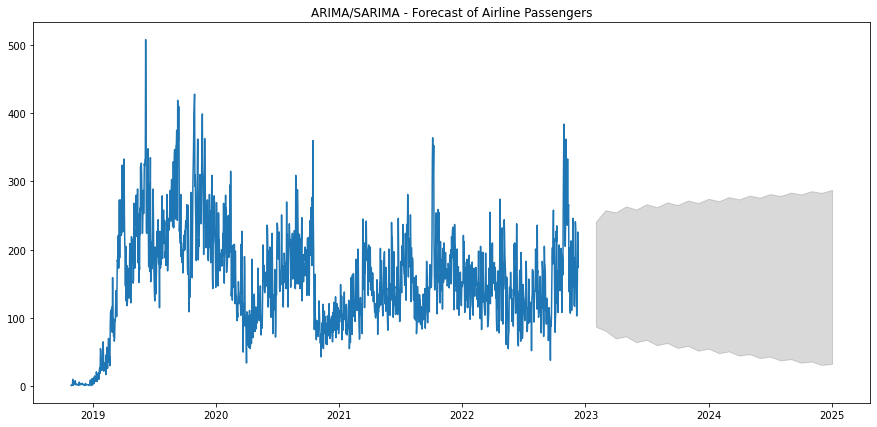

In [ ]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_merge_select_mhd_teh_select_date_f.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_merge_select_mhd_teh_select_date_f["count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_merge_select_mhd_teh_select_date_f['count'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=0, n_jobs=-1,
                         seasonal=True, #set to seasonal
                         d=None, #order of the seasonal differencing
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=14915.045, Time=4.47 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16047.008, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=15339.792, Time=3.96 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15365.795, Time=4.09 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16045.255, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=15620.265, Time=2.15 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=14914.328, Time=9.87 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=15287.344, Time=5.06 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=14916.118, Time=32.46 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=14917.023, Time=12.77 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=14914.404, Time=11.89 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=15151.634, Time=5.42 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=14918.327, Time=12.82 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=15347.489, Time=2.59 sec
 ARIMA(1,0,0)(1

In [ ]:
SARIMA_model

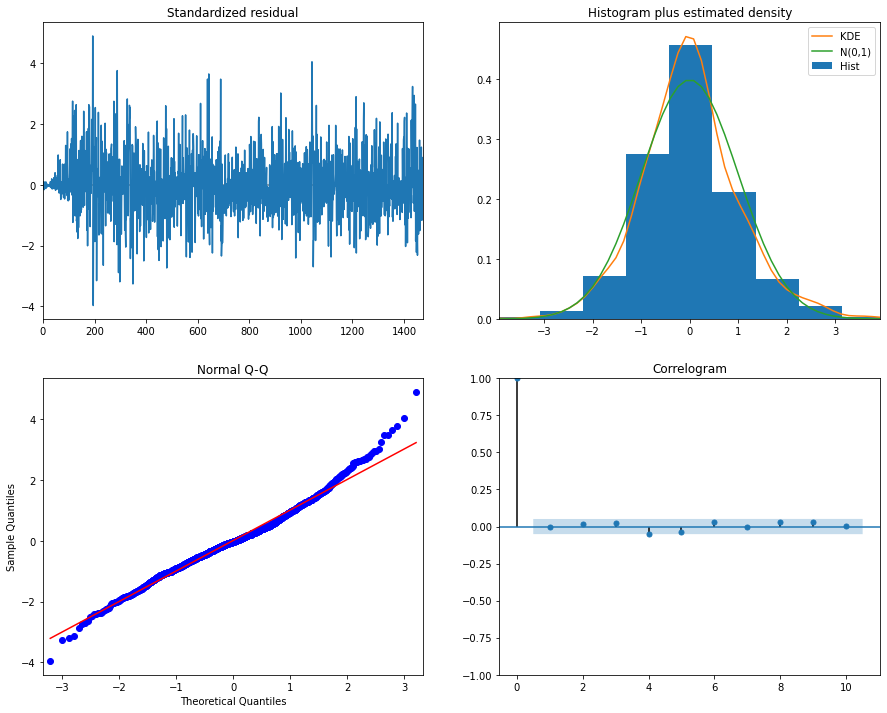

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

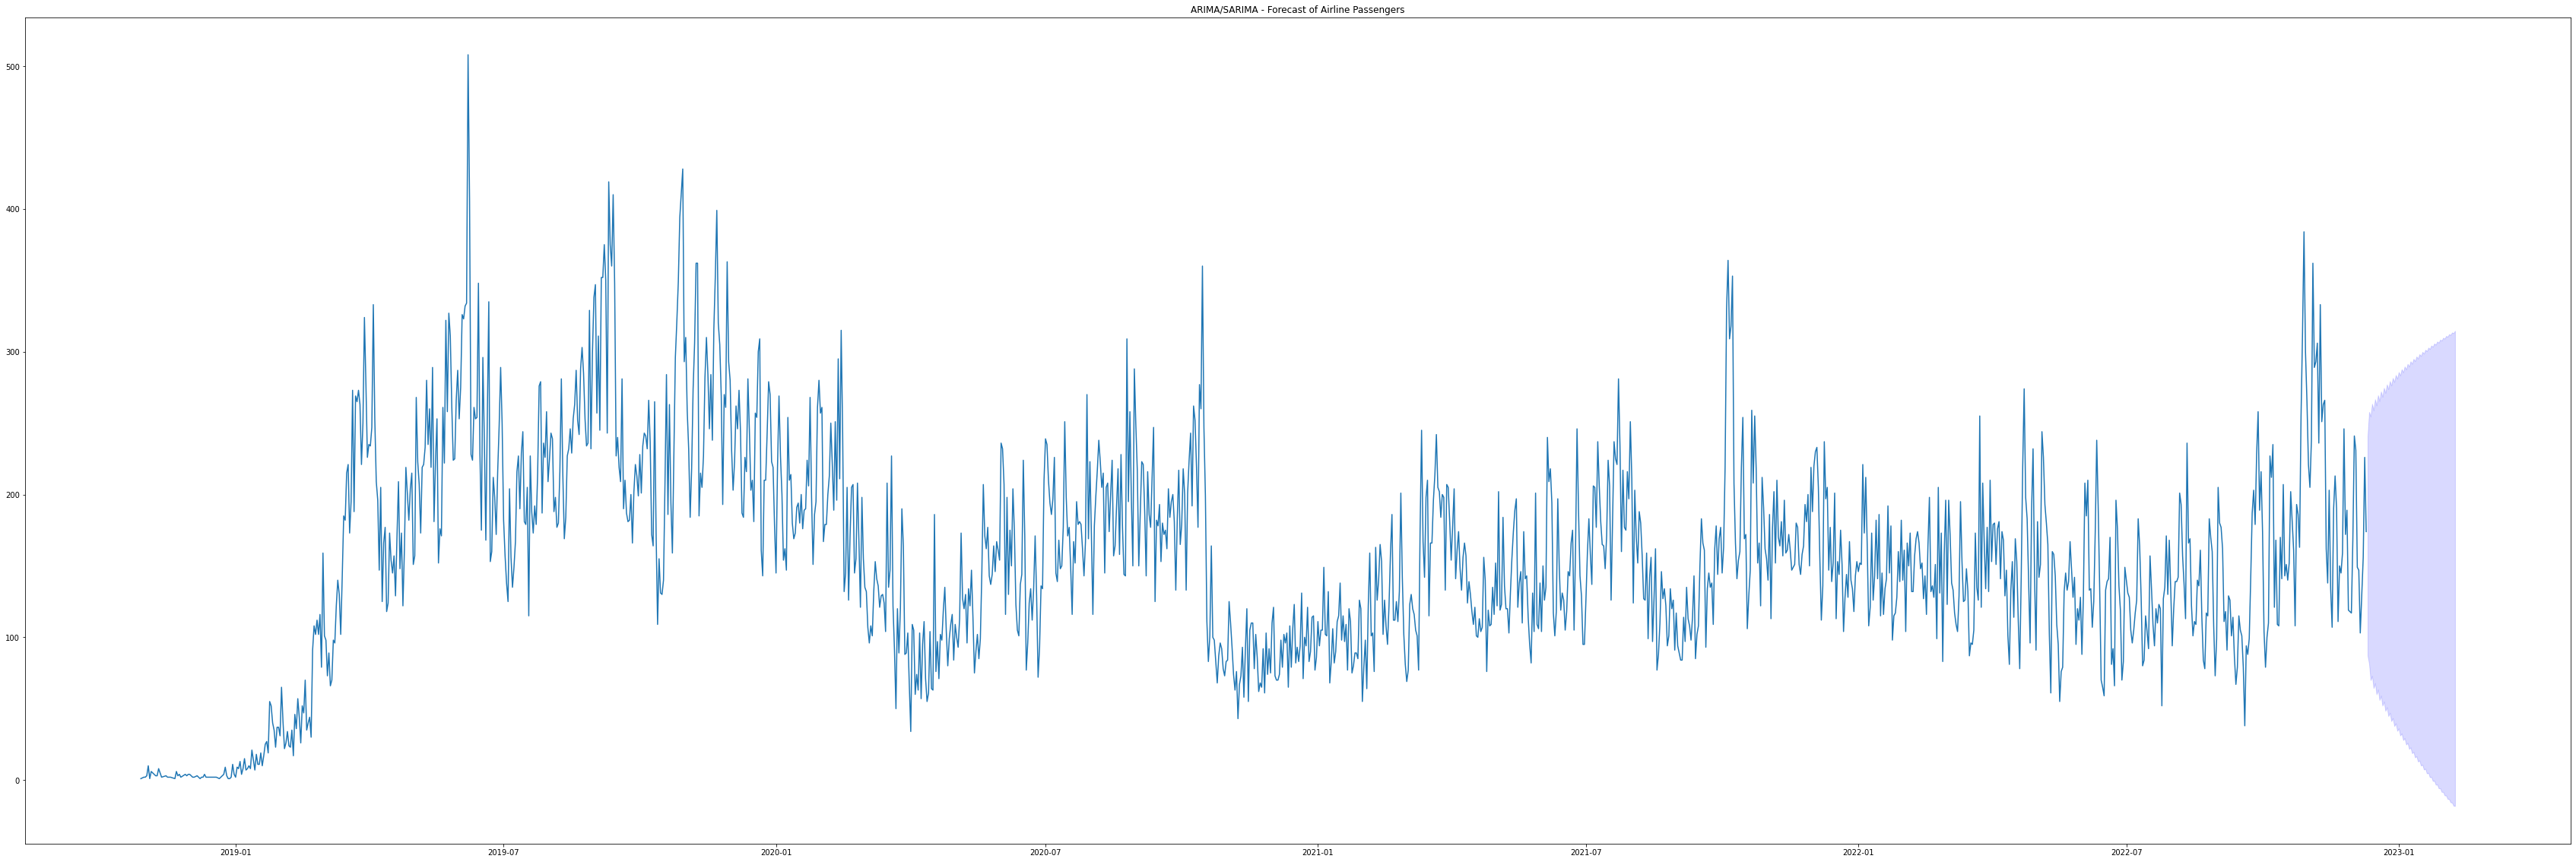

In [ ]:
def forecast(ARIMA_model, periods=60):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_merge_select_mhd_teh_select_date_f.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(60,20))
    plt.plot(df_merge_select_mhd_teh_select_date_f.index,df_merge_select_mhd_teh_select_date_f["count"], color='#1f76b4')
    plt.plot(fitted_series.index,fitted_series, color='#FF0000')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='b', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [ ]:
y = df_merge_select_mhd_teh_select_date_f['count']
yhat = SARIMA_model.predict_in_sample(n_periods=60, return_conf_int=True)[0]

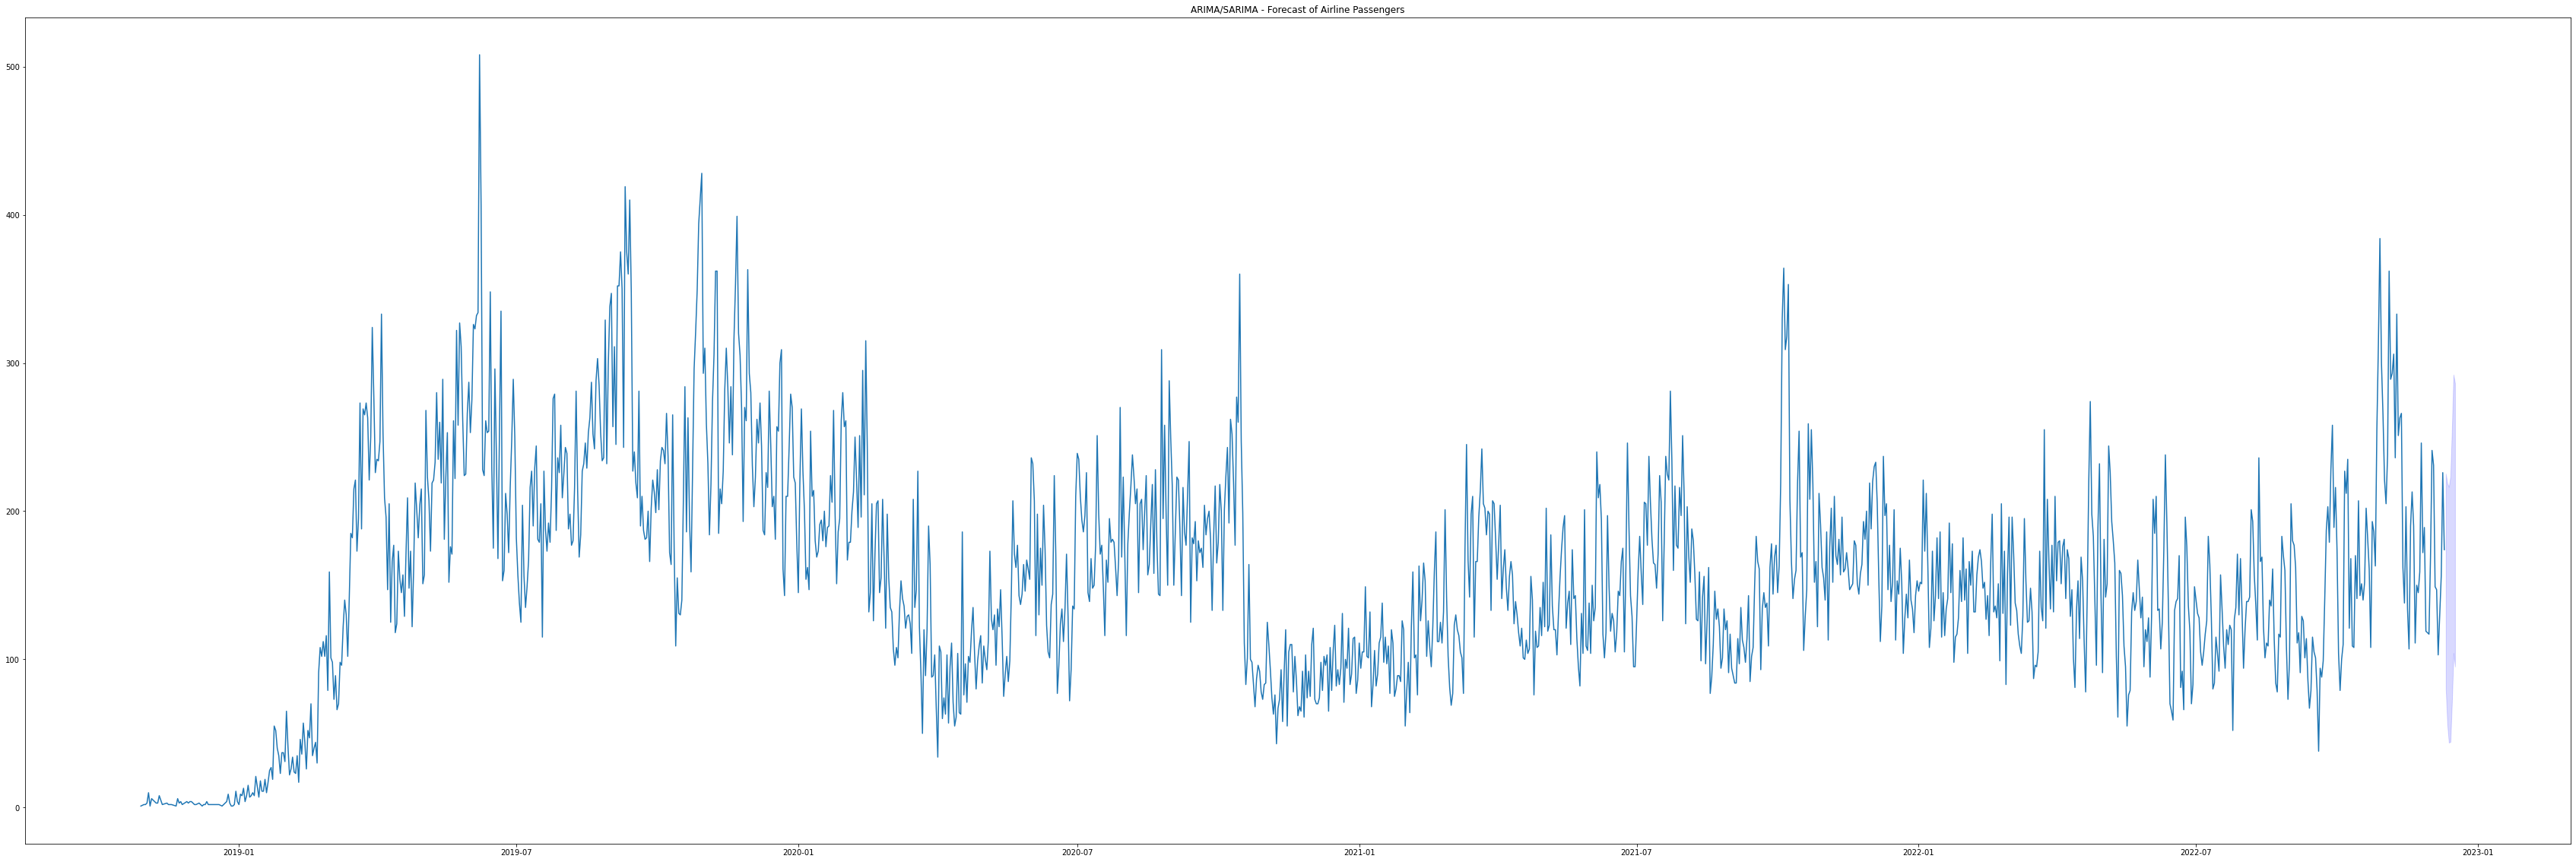

In [ ]:
forecast(SARIMA_model,7)

In [ ]:
SARIMA_model.predict_in_sample(n_periods=24, return_conf_int=True)[0]

miladi-flight-date
2018-10-29      0.446917
2018-10-31      0.447777
2018-11-01      0.449911
2018-11-02      0.451334
2018-11-03      0.453758
                 ...    
2022-12-06    143.151422
2022-12-07    122.505963
2022-12-08    160.994773
2022-12-09    192.222263
2022-12-10    209.746309
Length: 1483, dtype: float64

In [ ]:
 pd.date_range(df_merge_select_mhd_teh_select_date_f.index[-1] + pd.DateOffset(days=1), periods = 24, freq='D')

DatetimeIndex(['2022-12-11', '2022-12-12', '2022-12-13', '2022-12-14',
               '2022-12-15', '2022-12-16', '2022-12-17', '2022-12-18',
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
df_merge_select_mhd_teh_select_date_f.index[-1]

Timestamp('2022-12-10 00:00:00')

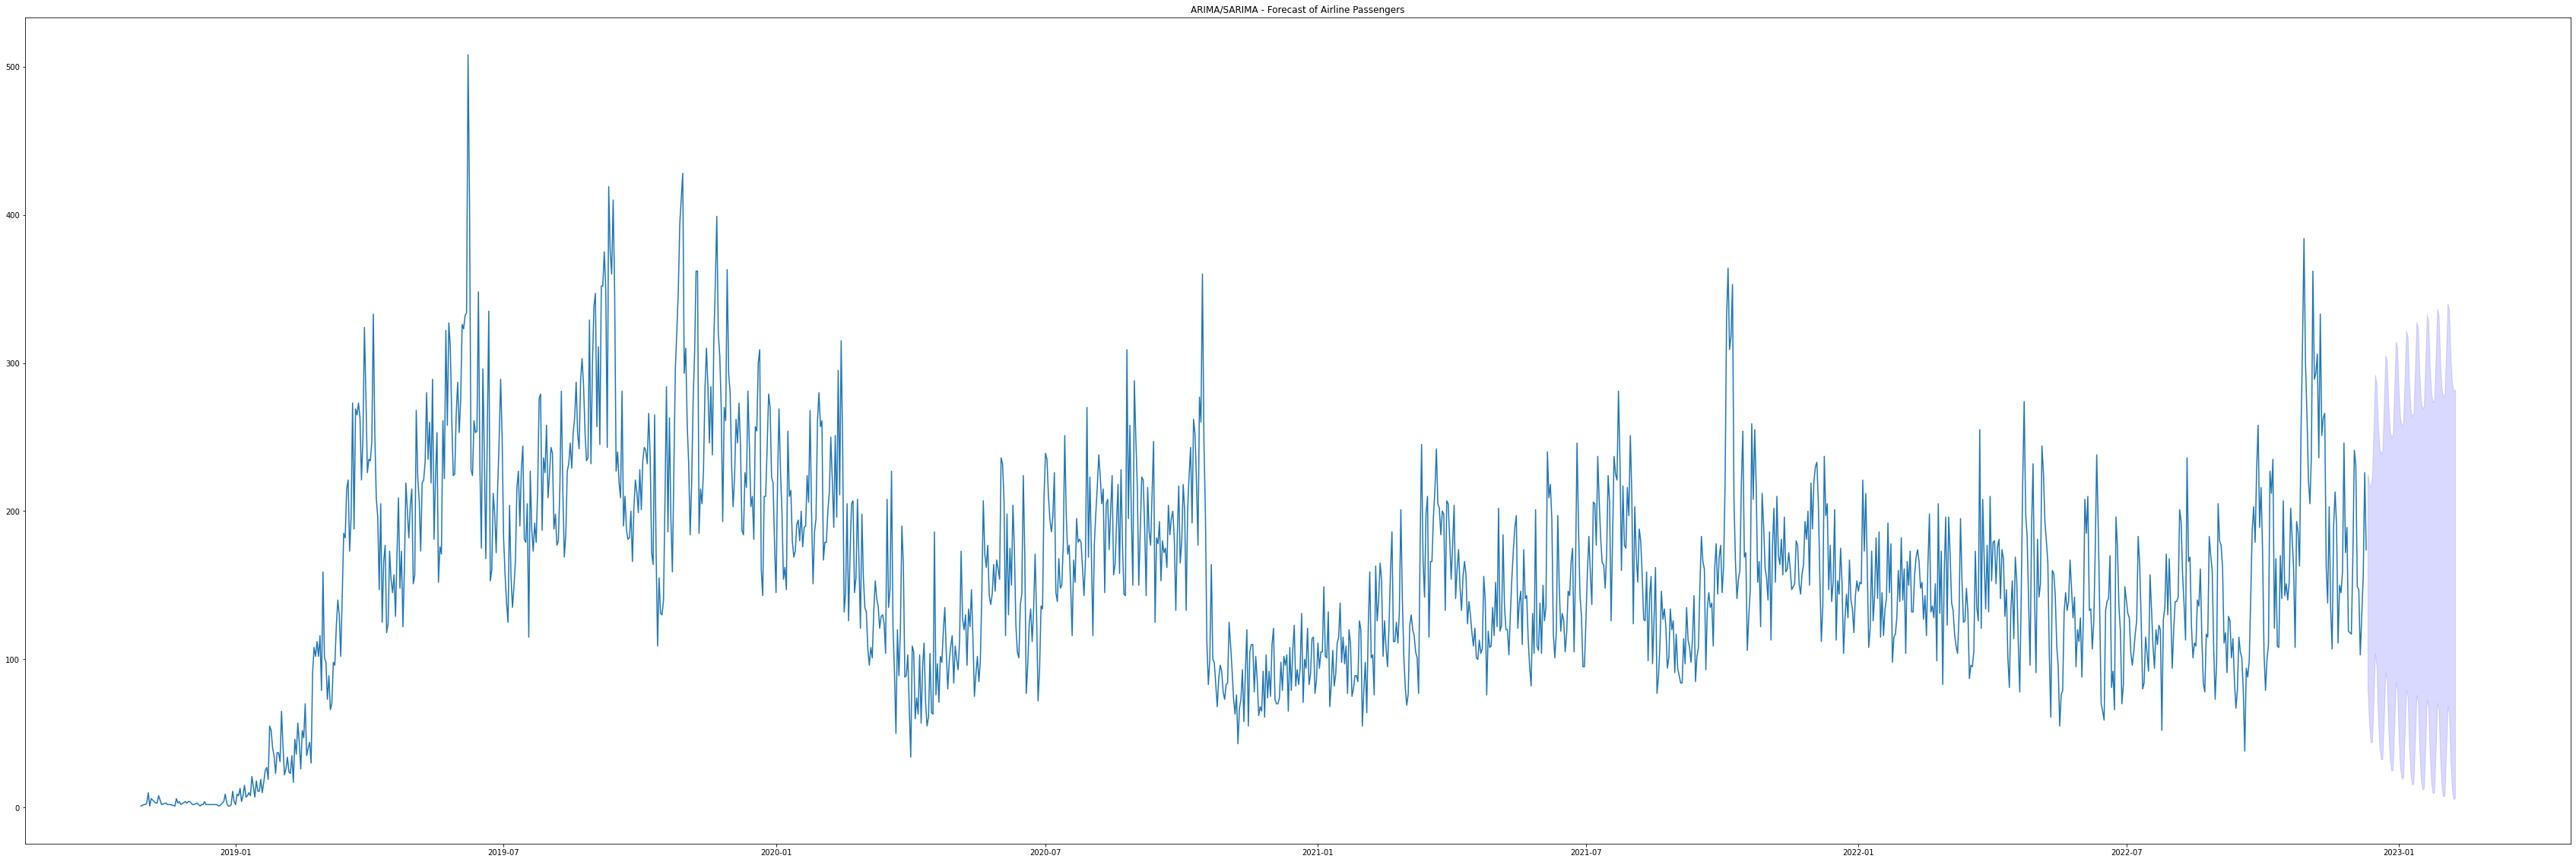

In [ ]:
forecast(SARIMA_model)

In [ ]:
#adding exogenous variable

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_merge_select_mhd_teh_select_date_f[['count']], exogenous=df_merge_select_mhd_teh_select_date_f[['holiday']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           njobs = -1,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=15778.129, Time=1.39 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16047.008, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=15339.792, Time=1.77 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15365.795, Time=2.18 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16045.255, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=15646.925, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=15217.443, Time=4.01 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=15032.443, Time=11.45 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=15030.624, Time=3.64 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=15033.750, Time=1.64 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=15032.405, Time=8.32 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=15030.781, Time=5.97 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=15034.613, Time=7.42 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=15747.888, Time=2.04 sec
 ARIMA(2,0,0)(1,1,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-d32d92163e00>", line 4, in <module>
    SARIMAX_model = pm.auto_arima(df_merge_select_mhd_teh_select_date_f[['count']], exogenous=df_merge_select_mhd_teh_select_date_f[['holiday']],
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/auto.py", line 701, in auto_arima
    sorted_res = search.solve()
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 345, in solve
    self._do_fit((p, d, q), (P + 1, D, Q, m)):
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 233, in _do_fit
    fit, fit_time, new_ic = self._fit_arima(
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/pyth

KeyboardInterrupt: ignored

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods


    fitted= SARIMAX_model.predict(n_periods=n_periods)
                                            
    index_of_fc = pd.date_range(df_merge_select_mhd_teh_select_date_f.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    # lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    # upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_merge_select_mhd_teh_select_date_f["count"], color='#1f76b4')
    plt.plot(fitted_series, color='yellow')
    # plt.fill_between(lower_series.index, 
    #                 lower_series, 
    #                 upper_series, 
    #                 color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

In [ ]:
sarimax_forecast(SARIMAX_model, periods=24)

In [ ]:
df_merge_select_mhd_teh_select_date_f['count'].describe()

In [ ]:
y = df_merge_select_mhd_teh_select_date_f['count']
yhat = SARIMAX_model.predict_in_sample(n_periods=24, return_conf_int=True)[0]
mean_absolute_percentage_error(y,yhat)

In [ ]:
q1=df_merge_select_mhd_teh_select_date_f['count'].quantile(0.30)
q3=df_merge_select_mhd_teh_select_date_f['count'].quantile(0.70)

print("The value of q1 is:",q1)
print("The value of q3 is:",q3)

In [ ]:
iqr = q3 - q1
print("The value of iqr is:",iqr)

In [ ]:
lower=q1-1.5*iqr
upper=q3+1.5*iqr

print("The value of upper bound is:",round(upper))
print("The value of lower bound is:",round(lower))

In [ ]:
y = df_merge_select_mhd_teh_select_date_f['count']
yhat = df_merge_select_mhd_teh_select_date_f['count'].rolling(6).mean()
mean_absolute_percentage_error(y,yhat)

In [ ]:
clean_data=df_merge_select_mhd_teh_select_date_f[((df_merge_select_mhd_teh_select_date_f['count']<(296))  &  (df_merge_select_mhd_teh_select_date_f['count']>(108)))]
clean_data

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(clean_data['count'], start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=0, n_jobs=-1,
                         seasonal=True, #set to seasonal
                         d=None, #order of the seasonal differencing
                         D=1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [ ]:
# # p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(clean_data['count'], order=(0,0,5), 
                                        seasonal_order=(0,1,1,7)).fit(disp=-1)
print(best_model.summary())

In [ ]:
166 * 17 / 100

In [ ]:
y = clean_data['count']
yhat = best_model.predict(n_periods=24, return_conf_int=True)
mean_absolute_percentage_error(y,yhat)

In [ ]:
best_model_s=sm.tsa.statespace.SARIMAX(clean_data['count'],exogenous=clean_data[['holiday']]
, order=(5,0,5), 
                                        seasonal_order=(1,1,1,7)).fit(disp=-1)
print(best_model_s.summary())

In [ ]:
best_model_s.forcast()

In [ ]:
y = clean_data['count']
yhat = best_model_s.predict(n_periods=24, return_conf_int=True)
mean_absolute_percentage_error(y,yhat)

In [ ]:
forecast(SARIMA_model)

In [ ]:
best_model.predict(n_periods=24, return_conf_int=True)

In [ ]:
y = clean_data['count']
yhat = clean_data['count'].rolling(7).mean()
mean_absolute_percentage_error(y,yhat)

In [ ]:
y

In [ ]:
df_merge_select_mhd_teh_select_date.loc[:'2022-02-01']

In [ ]:
df_merge_select_mhd_teh_select_date.shape

In [ ]:
15392     / 19822

# Pycaret

In [ ]:
# --- Installing Libraries ---
# !pip install pycaret
# !pip install  pycaret[full]
# !pip install pycaret-ts-alpha --user
# !pip install kaleido
# --- Installing Libraries ---
!pip install --use-deprecated=legacy-resolver pycaret
!pip install --use-deprecated=legacy-resolver pycaret[full] --user
!pip install --use-deprecated=legacy-resolver pycaret-ts-alpha --user
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached numba-0.54.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.3 MB)
  Using cached scipy-1.5.4-cp38-cp38-manylinux1_x86_64.whl (25.8 MB)
  Using cached llvmlite-0.37.0-cp38-cp38-manylinux2014_x86_64.whl (26.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.0
    Uninstalling imbalanced-learn-0.10.0:
      Successfully uninstalled imbalanced-learn-0.10.0
  A

In [ ]:
! pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# --- Importing Libraries ---
import datetime
import numpy as np
import pandas as pd
import warnings
import pycaret
import kaleido
import plotly.express as px

from pycaret.time_series import *
from pycaret.utils import enable_colab

# --- Libraries Settings ---
warnings.filterwarnings('ignore')
enable_colab()

/root/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ImportError: ignored

In [ ]:
import 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/charter project/tehran_mashhad.csv')
df.head()

NameError: ignored

In [ ]:
pd.read_csv()